## Enzo Yamamura



Ativando o Drive com meus dados e importando tabelas:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Pacotes necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud, STOPWORDS
from statsmodels.tsa.seasonal import seasonal_decompose

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# Importando direto do Drive
btc = pd.read_csv('/content/drive/MyDrive/Enzo/btc_daily.csv')
reddit = pd.read_csv('/content/drive/MyDrive/Enzo/reddit.csv')

In [4]:
# Dando uma olhadinha na base de BTC:
btc.head()

,Date,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
0,2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05
1,2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06
2,2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06
3,2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07
4,2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06


In [5]:
# Dando uma olhadinha na base de comentários do Reddit:
reddit.head()

,Unnamed: 0,subreddit,score,Created Date,Comment,Sentiment,score_norm,Sentiment_weighted,Day
0,0,millionairemakers,2.0,2015-01-01 00:00:43,Starting out is tough. Strict Regulations in t...,0.8163,0.053064,0.043316,2015-01-01
1,1,changetip,0.0,2015-01-01 00:01:22,To quit looking at the price of btc every 15 m...,0.0000,0.052999,0.000000,2015-01-01
2,2,sportsbook,2.0,2015-01-01 00:01:22,That's the reason I dislike betting using bitc...,0.1441,0.053064,0.007646,2015-01-01
3,3,Bitcoin,2.0,2015-01-01 00:01:28,"Yup, you probably already installed bitcoin-se...",0.5927,0.053064,0.031451,2015-01-01
4,4,Bitcoin,0.0,2015-01-01 00:01:46,I really like Coinbase for its iPhone app. I h...,0.9657,0.052999,0.051181,2015-01-01


Quais são os subreddits com mais menções ao Bitcoin no período?

In [6]:
top10 = reddit.subreddit.value_counts().to_frame('Contagem')[:10].reset_index()
top10_l = top10['index'].to_list()
fig = px.bar(top10, x='index', y='Contagem', text= 'Contagem')


fig.update_layout(
    showlegend=False,
    title = "Top 10 fóruns com mais menções ao Bitcoin (2015-2019)",
    xaxis_title = "Subreddit",
    yaxis_title = "Contagem de Menções"
)
fig.show()

A despeito dos subreddits com nomes questionáveis, os subreddits em que as mençòes de Bitcoin predominam são: /Bitcoin, /btc, /CryptoCurrency, /BitcoinMarkets.

É sabido que fóruns online são os lares de "Trolls". Ainda assim, com a finalidade de captar humor geral de mercado, não vamos descartar informações de nenhum subreddit com base em seu nome, público ou seriedade.

Vale ressaltar que, atualmente, BTC é moeda aceita em vários meios diferentes, com suas oscilações afetando economias de nicho inteiras, o que justifica o aparecimento de fóruns peculiares acima.

Ademais, com a democratização do acesso a tecnologia e disseminaçào dos conhecimentos do Bitcoin, trata-se de um investimento com poucas barreiras a entrada. Se restringíssemos as análises apenas aos fóruns "sérios" corremos o risco de perdermos informações relevantes sobre como as pessoas reais que compram e vendem BTC estão antecipando ou reagindo à oscilações.

In [7]:
# Verificando concentração:

conc = round(reddit.subreddit.isin(top10['index'][:4].to_list()).sum(axis=0) / len (reddit),3)
forums = reddit['subreddit'].unique().shape[0]
print(f'Aproximadamente {conc} estão nos 4 fóruns acima, dentre um total de {forums} subreddits.')

Aproximadamente 0.513 estão nos 4 fóruns acima, dentre um total de 22260 subreddits.


Será que existe algum tipo de viés nos fóruns?

In [8]:
# Verificcando viés em fóruns:
bins = [-1,-0.1,0.1,1]
sent = {'(-1.0, -0.1]':'negativo', '(-0.1, 0.1]':'neutro', '(0.1, 1.0]':'positivo'}
bias = reddit.groupby(['subreddit', pd.cut(reddit.Sentiment, bins)]).size().to_frame('contagem').reset_index()
bias.Sentiment = bias.Sentiment.astype(str).map(sent)

# top10_l = top10['index'][:10].to_list()
bias.query('subreddit in @top10_l',inplace=True)


fig = px.bar(bias, x='subreddit', y='contagem', color ='Sentiment', text= 'contagem')


fig.update_layout(
    showlegend=True,
    title = "Top 10 fóruns com mais menções ao Bitcoin (2015-2019) - Polarização dos Comentários de BTC",
    xaxis_title = "Subreddit",
    yaxis_title = "Contagem de Menções"
)

fig.update_xaxes(categoryorder = 'total descending')

fig.show()

Vimos uma aparente relação entre volume de postagens sobre BTC no fórum e viés otimista.

Porém, em nenhum caso acima o volume de comentários negativos é desprezível.
Conseiderando a tendência geral de alta observada entre 2015-2019, podemos aventar que gerou um ambiente mais otimista nos principais fóruns.

Vale lembrar que, em volume de usuários, Bitcoin, btc, CryptoCurrency e BitcoinMarkets são os maiores fóruns de BTC do Reddit, o que pode ajudar a explicar a concentração.

A partir daqui separaremos a base de comentários do Reddit em 2 bases:

* top 4 fóruns: 'Bitcoin','btc','CryptoCurrency', 'BitcoinMarkets'

* base completa

O intuito é averiguar se fóruns especializados refletem melhor as oscilações de BTC

In [9]:
# top 4 subreddits especializados:
top4 = reddit.query("subreddit in ['Bitcoin','btc','CryptoCurrency', 'BitcoinMarkets']")

In [10]:
top4.shape

(2599302, 9)

A base total conta com pouco mais de 5KK obs enquanto a com os top 4 conta com 2.5KK obs.

In [11]:
# Agregando por dias:
reddit_ = reddit.copy()

# Agruparemos em dias e soma, média, máximo e mínimo diário dos sentimentos ponderados
reddit_ = reddit_.groupby('Day')['Sentiment_weighted'].agg({'count', 'sum', 'mean', 'median'})

top4_ = top4.groupby('Day')['Sentiment_weighted'].agg({'count', 'sum', 'mean', 'median'})

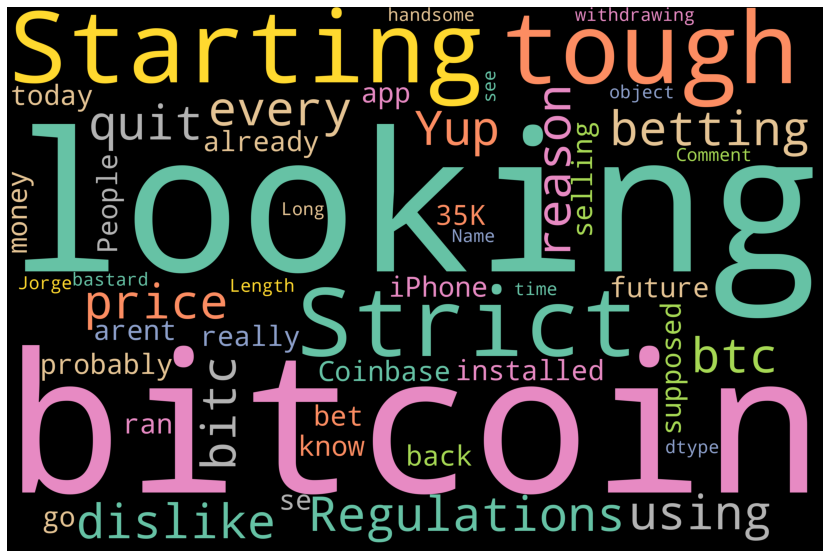

In [12]:
# Wordcloud:
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(25, 10))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");


# Palavras mais mencionadas:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(str(reddit.Comment))
# Plot
plot_cloud(wordcloud)

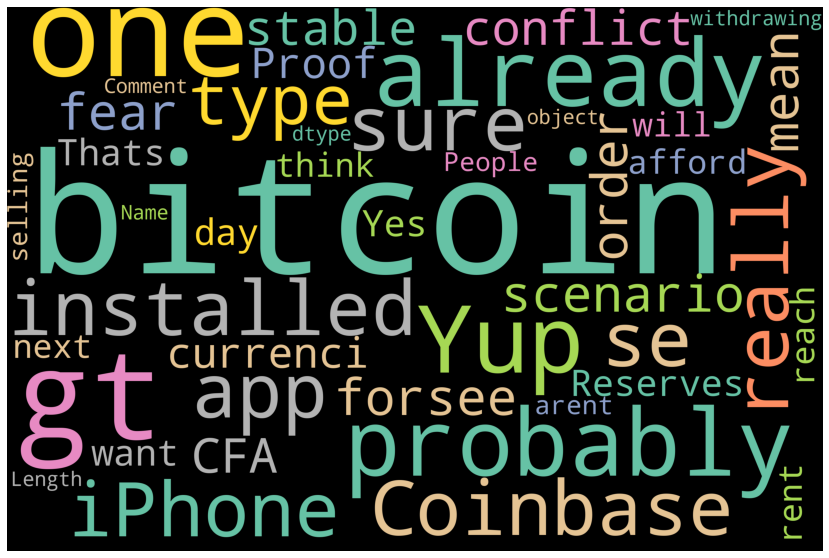

In [13]:
# Palavras mais mencionadas nos top 4:
wordcloud = WordCloud(width= 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False, stopwords = STOPWORDS).generate(str(top4.Comment))
# Plot
plot_cloud(wordcloud)

Percebemos que as palavras mais utilizadas nos comentários relacionados a BTC são diferentes quando consideramos os 4 fóruns especializados e todo o Reddit.

Chama atenção a quantidade de palavras infladas contendo regulamentações, restrições, conflitos e iPhone. Todos fatores exógenos de difícil previsibilidade. Mas também observamos palavras relevantes como reservas, liquidação, apostas e afins.

In [14]:
# Plotando no tempo:
for x in reddit_.columns:
  fig = px.line(reddit_[x])
  fig.update_layout(title=x)
  fig.show()

Nota-se que em Janeiro de 2018 houve algo que impactou os sentimentos positivamente.

Curiosamente, a queda na polarização somada por todo Reddit começa em dezembro de 2017, aparentemente antecipando o _crash_ histórico do que foi chamado "bolha do BtC", quando na segunda quinzena de Janeiro verificou-se a queda de 25% na criptomoeda.

In [15]:
# Repetindo análise para as top4:
# Plotando no tempo:
for x in top4_.columns:
  fig = px.line(top4_[x])
  fig.update_layout(title=x)
  fig.show()

Acima percebemos que o **mesmo fenômeno se repete** para os 4 top 4 fóruns (e especializados) de BTC.

Vale observar que o **volume de comentários também acompanha os eventos mais drásticos, tanto para Janeiro 2018 quanto para Julho de 2019.

In [16]:
btc.head()

,Date,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
0,2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05
1,2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06
2,2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06
3,2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07
4,2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06


## A partir daqui analisaremos a série do BTC:

In [17]:
# Plotando ao longo do tempo:
fig = px.line(btc, y= 'Close',x='Date')
fig.update_layout(title ='Série Histórica Bitcoin - 2015-2019')
fig.show()

In [18]:
fig = go.Figure(data = [go.Candlestick(x=btc['Date'], open = btc['Open'], high = btc['High'], low = btc['Low'], close = btc['Close'])])

fig.update_layout(title ='Série Histórica Bitcoin - 2015-2019')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Acima conseguimos ver o mesmo fenômeno se repetindo na mesma data. vendo mais especificamente entre dezembro-17 e janeiro-18:

In [19]:
fig = go.Figure(data = [go.Candlestick(x=btc['Date'], open = btc['Open'], high = btc['High'], low = btc['Low'], close = btc['Close'])])

fig.update_layout(title ='Série Histórica Bitcoin - 2015-2019')
fig.update_layout(xaxis_rangeslider_visible=True)
fig.show()

Olhando de forma mais granular percebemos que consistentemente o BTC abriu acima do que fechou em todos os dias a partir da segunda semana de dezembro.

Fica o questionamento de relação entre causa e efeito entre variação no BTC e humor nos fóruns do Reddit. Isto pois na época ocorreram vários fatos simultaneamente (alguns podendo ser considerados _Black Swams_):

* Boom histórico em 2017

* Queda ao final de Dezembro (especulativa)

* Queda no começo de Janeiro por rumores de banimento na Coréia do Sul

* Hackers invadiram o Coincheck, maior mercado OTC de criptomoedas do Japão, no final de Janeiro

A hipótese é de que:

Dada a oferta fixa do ativo, que gera oscilação baseada em:
1. Demanda (oferta fixa)
2.Fatores exógenos (banimentos, conflitos, declarações de big players)

  **Há alguma relação entre humores da internet e oscilação no BTC, seja reativa ou causal. Tal como notícias impactam o preço de ativos a opinião popular massificada pelas mídias digitais deve ter algum impacto especulativo nas criptomoedas.**

### Análise de Séries Temporais do Bitcoin

In [20]:
# Para ter ideia de tendência:
# lembrando de também setar índice como data na base principal:
btc = btc.set_index('Date')
btc_ = btc.copy()


btc_['mm20d'] = btc_['Close'].rolling(20).mean()
btc_['md20d'] = btc_['Close'].rolling(20).median()
btc_['dp20d'] = btc_['Close'].rolling(20).std()
fig = px.line(btc_, y=['mm20d','md20d','dp20d'])
fig.update_layout(title = 'Tendência Close BTC (USD) ao longo do Tempo')
fig.show()

In [21]:
# Decompondo a série temporal do BTC:
btc_ = btc_.iloc[:,:-3]

# try:
#   btc_.index = pd.to_datetime(btc_.index)
#   result = seasonal_decompose(btc_['Close'], model='additive')
#   result.plot()

#   plt.show()
# except: raise ValueError('Existem NaNs em Close')


O erro acima indica que existem células vazias dentro do campo Close.

Vamos contar quantos NaNs temos por coluna:

In [22]:
btc_.isna().sum()

Open                 3
High                 3
Low                  3
Close                3
Volume_(BTC)         0
Volume_(Currency)    0
dtype: int64

In [23]:
cols = ['Open', 'High','Low','Close']
btc_[btc_[cols].isna().all(axis=1)]

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Date,,,,,,
2015-01-06,NaN,NaN,NaN,NaN,0.0,0.0
2015-01-07,NaN,NaN,NaN,NaN,0.0,0.0
2015-01-08,NaN,NaN,NaN,NaN,0.0,0.0


Temos 3 dias consecutivos no começo da série em 2015 com valores de OHLC nulos. Para não deixarmos um buraco na série vamos preencher com os valores do dia 05-01-2015 de volume e close como de open, mantendo open e close constantes e zerando high e low para as 4 colunas, assumindo constância.

In [24]:
btc_.loc['2015-01-05':'2015-01-09']

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Date,,,,,,
2015-01-05,264.55,280.0,264.07,276.80,9528.271002,2.596898e+06
2015-01-06,NaN,NaN,NaN,NaN,0.000000,0.000000e+00
2015-01-07,NaN,NaN,NaN,NaN,0.000000,0.000000e+00
2015-01-08,NaN,NaN,NaN,NaN,0.000000,0.000000e+00
2015-01-09,272.45,305.0,272.45,293.97,9914.249594,2.898085e+06


In [25]:
# Preenchendo para esta cópia
btc_.loc['2015-01-06':'2015-01-08','Volume_(Currency)'] = btc_.loc['2015-01-05','Volume_(Currency)']
btc_.loc['2015-01-06':'2015-01-08','Volume_(BTC)'] = btc_.loc['2015-01-05','Volume_(BTC)']
btc_.loc['2015-01-06':'2015-01-08','Open'] = btc_.loc['2015-01-05','Close']
btc_.loc['2015-01-06':'2015-01-08','Close'] = btc_.loc['2015-01-05','Close']

In [26]:
btc_.loc['2015-01-05':'2015-01-09']

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency)
Date,,,,,,
2015-01-05,264.55,280.0,264.07,276.80,9528.271002,2.596898e+06
2015-01-06,276.80,NaN,NaN,276.80,9528.271002,2.596898e+06
2015-01-07,276.80,NaN,NaN,276.80,9528.271002,2.596898e+06
2015-01-08,276.80,NaN,NaN,276.80,9528.271002,2.596898e+06
2015-01-09,272.45,305.0,272.45,293.97,9914.249594,2.898085e+06


In [27]:
# Preenchendo na base principal também:
btc.loc['2015-01-06':'2015-01-08','Volume_(Currency)'] = btc.loc['2015-01-05','Volume_(Currency)']
btc.loc['2015-01-06':'2015-01-08','Volume_(BTC)'] = btc.loc['2015-01-05','Volume_(BTC)']
btc.loc['2015-01-06':'2015-01-08','Open'] = btc.loc['2015-01-05','Close']
btc.loc['2015-01-06':'2015-01-08','Close'] = btc.loc['2015-01-05','Close']

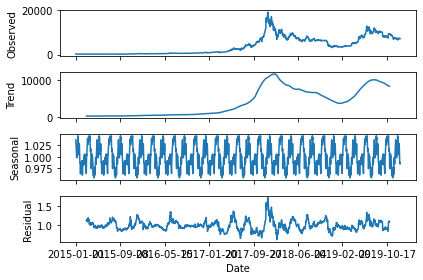

In [28]:
# Decompondo novamente, sem os NaNs:
result = seasonal_decompose(btc_['Close'], model='multiplicative', freq = 120)
result.plot()
plt.show()

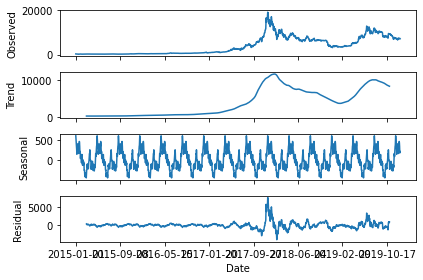

In [29]:
# Decompondo novamente, sem os NaNs:
result = seasonal_decompose(btc_['Close'], model='additive', freq = 120)
result.plot()
plt.show()

Decompondo a série temporal de forma aditiva e multiplicativa percebemos que a aditiva parece gerar resíduos menores, fora momentos excepcionais supracitados.

Também percebe-se uma sazonalidade bem definida de 4 em 4 meses, aproximadamente (120 dias). Chegamos na frequência de 120 dias aumentando gradativamente até chegarmos no padrão sazonal acima.

***
## Análise relacional entre preço do Bitcoin e sentimentos no Reddit

In [30]:
# Plotando gráfico de linha simples entre as 2 séries temporais:


fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = reddit_.index,y = reddit_['sum'], name="Sentimentos do Reddit"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.index, y = btc['Close'], name = "Fechamento do Bitcoin em USD"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Variação de sentimentos no Reddit x Bitcoin (Close - USD) - 2015 a 2019",
    legend = dict(x=0.2, y=0.7)
)

# Set x-axis title
fig.update_xaxes(title_text="Datas (série diária)")

# Set y-axes titles
fig.update_yaxes(title_text="Sentimentos do Reddit", secondary_y=False)
fig.update_yaxes(title_text="Fechamento do Bitcoin em USD", secondary_y=True)

fig.show()

In [31]:
# Plotando gráfico de linha simples entre as 2 séries temporais:


fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = top4_.index,y = top4_['sum'], name="Sentimentos nos fóruns especializados"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.index, y = btc['Close'], name = "Fechamento do Bitcoin em USD"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Variação de sentimentos nos top 4 Subreddits x Bitcoin (Close - USD) - 2015 a 2019",
    legend = dict(x=0.05, y=0.7)
)

# Set x-axis title
fig.update_xaxes(title_text="Datas (série diária)")

# Set y-axes titles
fig.update_yaxes(title_text="Sentimentos do Reddit", secondary_y=False)
fig.update_yaxes(title_text="Fechamento do Bitcoin em USD", secondary_y=True)

fig.show()

Ainda é cedo para aventar hipóteses de previsibilidade, mas fica flagrante que as séries ao menos **replicam muito bem as tendências** uma da outra.

A partir daqui olharemos apenas o Reddit na totalidade, _tendo em vista que não observamos muita diferença entre os sentimentos nos fóruns especializados e utilizar todo Reddit._

In [32]:
# Plotando gráfico de linha simples entre as 2 séries temporais:


fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = reddit_.index,y = reddit_['sum'].shift(14), name="Sentimentos do Reddit defasados em 2 semanas"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.index, y = btc['Close'], name = "Fechamento do Bitcoin em USD"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Variação de sentimentos no Reddit (-14 dias) x Bitcoin (Close - USD) - 2015 a 2019",
    legend = dict(x=0.1, y=0.7)
)

# Set x-axis title
fig.update_xaxes(title_text="Datas (série diária)")

# Set y-axes titles
fig.update_yaxes(title_text="Sentimentos do Reddit lag 14 dias", secondary_y=False)
fig.update_yaxes(title_text="Fechamento do Bitcoin em USD", secondary_y=True)

fig.show()

Surpreendentemente, alguns dos picos do BTC são melhor capturados quando defasamos os sentimentos do Reddit em 2 semanas.

Mas e a relação inversa?

In [33]:
# Plotando gráfico de linha simples entre as 2 séries temporais:


fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x = reddit_.index,y = reddit_['sum'], name="Sentimentos do Reddit"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x = btc.index, y = btc['Close'].shift(14), name = "Fechamento do Bitcoin em USD defasado em 2 semanas"),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="Variação de sentimentos no Reddit x Bitcoin lag 2 semanas (Close - USD) - 2015 a 2019",
    legend = dict(x=0.05, y=0.7)
)

# Set x-axis title
fig.update_xaxes(title_text="Datas (série diária)")

# Set y-axes titles
fig.update_yaxes(title_text="Sentimentos do Reddit", secondary_y=False)
fig.update_yaxes(title_text="Fechamento do Bitcoin em USD lag 14 dias", secondary_y=True)

fig.show()

Antecipando a variação no fechamento do BTC em 2 semanas não temos o mesmo efeito.

A visualização simultânea das séries temporais parece indicar que sentimentos antecipam o Close de BTC, e a recíproca não é verdadeira.

In [34]:
# Sentimento x BTC
df = btc.join(reddit_)

# Renomeando colunas:

df.rename(columns = {'mean': 'sent_mean','count': 'comment_count','median':'sent_md','sum':'sent_sum'},inplace=True)
# Sentimentos do Reddit defasados em 2 semanas:
df['sent_sum_2w'] = df['sent_sum'].shift(14)
df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),sent_sum,sent_md,sent_mean,comment_count,sent_sum_2w
Date,,,,,,,,,,,
2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05,15.780143,0.013339,0.011820,1335,NaN
2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06,14.801278,0.008572,0.009464,1564,NaN
2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06,19.012670,0.012008,0.009646,1971,NaN
2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07,24.593739,0.012045,0.009981,2464,NaN
2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06,24.207751,0.013149,0.010448,2317,NaN


In [35]:
# Close x Sentimento no Reddit:
fig = px.scatter(df, x = 'Close', y = 'sent_sum', title ='BTC Close (USD) x Sentimentos do Reddit')

fig.update_xaxes(title_text="BTC Close (USD)")
fig.update_yaxes(title_text="Soma de Sentimentos do Dia")

fig.show()

In [36]:
# Close x Sentimento no Reddit:
fig = px.scatter(df, x = 'Close', y = 'sent_sum', title ='BTC Close (USD) x Sentimentos do Reddit',log_x=True)

fig.update_xaxes(title_text="BTC Close (USD) - em log")
fig.update_yaxes(title_text="Soma de Sentimentos do Dia")

fig.show()

In [37]:
# Close x Sentimento no Reddit Defasado em 2 Semanas:
fig = px.scatter(df, x = 'Close', y = 'sent_sum_2w', title ='BTC Close (USD) x Sentimentos do Reddit',log_x=True)

fig.update_xaxes(title_text="BTC Close (USD) - em log")
fig.update_yaxes(title_text="Soma de Sentimentos do Dia - lag 2 semanas")

fig.show()

Parece haver uma associação entre preço do Bitcoin e Sentimentos do Reddit.

Mesmo quando defasamos sentimentos em 2 semanas esta se mantém.

_Quanto maior o sentimento maior o fechamento BTC e/ou vice versa_.

**Daqui em diante consideraremos a relação olhando para sentimentos do Reddit defasados de 2 em 2 semanas.**

In [38]:
# Close x Sentimento no Reddit x Volume negociado BTC:
fig = px.scatter(df, x = 'Close', y = 'sent_sum_2w', size = 'Volume_(BTC)',size_max=45\
                 , title ='BTC Close (USD) x Sentimentos do Reddit (lag 2 semanas) x Volume Negociado'\
                 , log_x=False)

fig.update_xaxes(title_text="BTC Close (USD)")
fig.update_yaxes(title_text="Soma de Sentimentos do Dia")

fig.show()

In [39]:
# Defasando volume de comentários:
df['comment_count_2w'] = df['comment_count'].shift(14)

df['comment_count_2w'].fillna(0,inplace=True)
# Close x Sentimento no Reddit x Volume de Comentários:
fig = px.scatter(df, x = 'Close', y = 'sent_sum_2w', size = 'comment_count_2w',size_max=45\
                 , title ='BTC Close (USD) x Sentimentos do Reddit (lag 2 semanas) x Volume de Comentários (lag 2 semanas)'\
                 , log_x=False)

fig.update_xaxes(title_text="BTC Close (USD)")
fig.update_yaxes(title_text="Soma de Sentimentos defasados em 2 semanas")

fig.show()

O gráfico acima é elucidativo. Considerando tanto sentimento do Reddit quanto Volume de comentários defasados em 2 semanas:

* Há relação positiva entre sentimentos defasados e preços do BTC

* Além disso, comentários também são tanto **mais volumosos e mais polarizados positivamente 2 semanas antes de valores mais altos de fechamento de Bitcoin**.

In [40]:
df.head(2)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),sent_sum,sent_md,sent_mean,comment_count,sent_sum_2w,comment_count_2w
Date,,,,,,,,,,,,
2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05,15.780143,0.013339,0.011820,1335,NaN,0.0
2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06,14.801278,0.008572,0.009464,1564,NaN,0.0


In [41]:
# Criando correlograma:
correl = round(df.corr(),3)
fig = px.imshow(correl.where(np.tril(correl).astype(np.bool)), color_continuous_scale='tealrose_r', text_auto=True)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor="#FFF",title='Matriz de Correlações',\
                  )
fig.update_coloraxes(showscale=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Percebemos que existe uma correlação de Pearson considerável entre:

* Soma diaria de sentimentos ponderados e Volume Transacionado de BTC (em USD)

* Soma diaria de sentimentos ponderados e OHLC diários do BTC (em USD)

* O mesmo para volume de comentários por dia

* **Tanto volume de comentários quanto soma de polarização diária possuem correlação maior quando defasados em 2 semanas**

Partiremos então para uma análise considerando defasagens dessas variáveis em semanas múltiplas de 2:

In [42]:
# Separando em lags:
# 'Open', 'Close', 'Volume_(BTC)', 'Volume_(Currency)','comment_count','sent_sum'
sent_lags = df[['Close','sent_sum']].copy()
sent_lags.head()

,Close,sent_sum
Date,,
2015-01-01,313.81,15.780143
2015-01-02,315.42,14.801278
2015-01-03,282.00,19.012670
2015-01-04,264.00,24.593739
2015-01-05,276.80,24.207751


In [43]:
# Defasando de 2 em 2 semanas:
for n in np.arange(2,12,2):
  sent_lags[f'sent_sum_{n}w'] = sent_lags['sent_sum'].shift(n*7)

sent_lags.head()

,Close,sent_sum,sent_sum_2w,sent_sum_4w,sent_sum_6w,sent_sum_8w,sent_sum_10w
Date,,,,,,,
2015-01-01,313.81,15.780143,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.42,14.801278,NaN,NaN,NaN,NaN,NaN
2015-01-03,282.00,19.012670,NaN,NaN,NaN,NaN,NaN
2015-01-04,264.00,24.593739,NaN,NaN,NaN,NaN,NaN
2015-01-05,276.80,24.207751,NaN,NaN,NaN,NaN,NaN


In [44]:
# Criando correlograma:
correl = round(sent_lags.corr(),3)
fig = px.imshow(correl.where(np.tril(correl).astype(np.bool)), color_continuous_scale='tealrose_r', text_auto=True)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor="#FFF",title='Matriz de Correlações: Close x Sentimento Reddit',\
                  )
fig.update_coloraxes(showscale=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



A matriz de correlações indica que o a correlação aumenta entre Sentimentos defasados e Fechamentos até 2 semanas, mas decái em defasagens posteriores.

**E volume de comentários?**

In [45]:
# Separando em lags:
# 'Open', 'Close', 'Volume_(BTC)', 'Volume_(Currency)','comment_count','sent_sum'
comm_lags = df[['Close','comment_count']].copy()
comm_lags.head()

,Close,comment_count
Date,,
2015-01-01,313.81,1335
2015-01-02,315.42,1564
2015-01-03,282.00,1971
2015-01-04,264.00,2464
2015-01-05,276.80,2317


In [46]:
# Defasando de 2 em 2 semanas:
for n in np.arange(2,12,2):
  comm_lags[f'comment_count{n}w'] = comm_lags['comment_count'].shift(n*7)

comm_lags.head()

,Close,comment_count,comment_count2w,comment_count4w,comment_count6w,comment_count8w,comment_count10w
Date,,,,,,,
2015-01-01,313.81,1335,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.42,1564,NaN,NaN,NaN,NaN,NaN
2015-01-03,282.00,1971,NaN,NaN,NaN,NaN,NaN
2015-01-04,264.00,2464,NaN,NaN,NaN,NaN,NaN
2015-01-05,276.80,2317,NaN,NaN,NaN,NaN,NaN


In [47]:
# Criando correlograma:
correl = round(comm_lags.corr(),3)
fig = px.imshow(correl.where(np.tril(correl).astype(np.bool)), color_continuous_scale='tealrose_r', text_auto=True)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor="#FFF",title='Matriz de Correlações: Close x Sentimento Reddit',\
                  )
fig.update_coloraxes(showscale=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



A mesma conclusão para contagem de comentários, até 2 semanas aumenta e decái posteriormente.

**E considerando o próprio preço do bitcoin defasado?**

In [48]:
# Separando em lags:

btc_lags = df[['Close']].copy()
btc_lags.head()

,Close
Date,
2015-01-01,313.81
2015-01-02,315.42
2015-01-03,282.00
2015-01-04,264.00
2015-01-05,276.80


In [49]:
# Defasando de 2 em 2 semanas:
for n in np.arange(2,12,2):
  btc_lags[f'Close{n}w'] = btc_lags['Close'].shift(n*7)

btc_lags.head()

,Close,Close2w,Close4w,Close6w,Close8w,Close10w
Date,,,,,,
2015-01-01,313.81,NaN,NaN,NaN,NaN,NaN
2015-01-02,315.42,NaN,NaN,NaN,NaN,NaN
2015-01-03,282.00,NaN,NaN,NaN,NaN,NaN
2015-01-04,264.00,NaN,NaN,NaN,NaN,NaN
2015-01-05,276.80,NaN,NaN,NaN,NaN,NaN


In [50]:
# Criando correlograma:
correl = round(btc_lags.corr(),3)
fig = px.imshow(correl.where(np.tril(correl).astype(np.bool)), color_continuous_scale='tealrose_r', text_auto=True)

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor="#FFF",title='Matriz de Correlações: Close x Sentimento Reddit',\
                  )
fig.update_coloraxes(showscale=False)
fig.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



Temos um efeito considerável do preço defasado em 2 semanas do próprio Bitcoin. Demonstrando uma autocorrelação.

---
#### E se considerarmos a variação no Bitcoin no dia (Close - Open) x Variação de Sentimentos?

In [51]:
# Close - Open por dia
df['C_O'] = df['Close'] - df['Open']

In [52]:
# Variação de sentimentos em relação ao dia anterior
df['sent_sum_var'] = df['sent_sum']-df['sent_sum'].shift(1)

df['sent_sum_2w_var'] = df['sent_sum_var'].shift(14)

df.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),sent_sum,sent_md,sent_mean,comment_count,sent_sum_2w,comment_count_2w,C_O,sent_sum_var,sent_sum_2w_var
Date,,,,,,,,,,,,,,,
2015-01-01,321.00,321.00,312.60,313.81,3087.436554,9.745096e+05,15.780143,0.013339,0.011820,1335,NaN,0.0,-7.19,NaN,NaN
2015-01-02,313.82,317.01,311.96,315.42,3468.281375,1.092446e+06,14.801278,0.008572,0.009464,1564,NaN,0.0,1.60,-0.978865,NaN
2015-01-03,315.42,316.58,280.00,282.00,21752.719146,6.475952e+06,19.012670,0.012008,0.009646,1971,NaN,0.0,-33.42,4.211393,NaN
2015-01-04,280.00,289.39,255.00,264.00,41441.278553,1.126676e+07,24.593739,0.012045,0.009981,2464,NaN,0.0,-16.00,5.581068,NaN
2015-01-05,264.55,280.00,264.07,276.80,9528.271002,2.596898e+06,24.207751,0.013149,0.010448,2317,NaN,0.0,12.25,-0.385988,NaN


In [53]:
# Variação x Sentimento no Reddit Defasado em 2 Semanas:
fig = px.scatter(df, x = 'C_O', y = 'sent_sum_2w_var', title ='BTC Variação Diária (USD) x Variação de Sentimentos do Reddit'\
                 ,log_x=False)

fig.update_xaxes(title_text="BTC Close - Open (USD)")
fig.update_yaxes(title_text="Variação de Sentimentos do Dia - lag 2 semanas")

fig.show()

Aparentemente não há relação entre variação de sentimentos defasados em 2 semanas e variação do preço do BTC, exceto um aumento na dispersão para valores mais extremos de oscilação no BTC.

In [54]:
# Variação x Sentimento no Reddit Defasado em 2 Semanas:
fig = px.scatter(df, x = 'C_O', y = 'sent_sum_2w', title ='BTC Variação Diária (USD) x Soma de Sentimentos do Reddit'\
                 ,log_x=False)

fig.update_xaxes(title_text="BTC Close - Open (USD")
fig.update_yaxes(title_text="Soma de Sentimentos do Dia - lag 2 semanas")

fig.show()

Curiosamente, a variação do BTC intraday parece ser menos relacionada aos sentimentos, tanto agregados / somados como em relação a sua variação.

Dados os achados acima, utilizaremos preço diário de fechamento do Bitcoin em dólares contra Soma Diária de Comentários do Reddit polarizados com VADER e ponderados por score com defasagem de 2 semanas.